In [48]:
%pip install deepface
%pip install tensorflow
%pip install matplotlib
%pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [49]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os

In [50]:
img_file = cv2.imread("dataset/train/0/Training_10120469.jpg")

In [51]:
img_file.shape

(48, 48, 3)

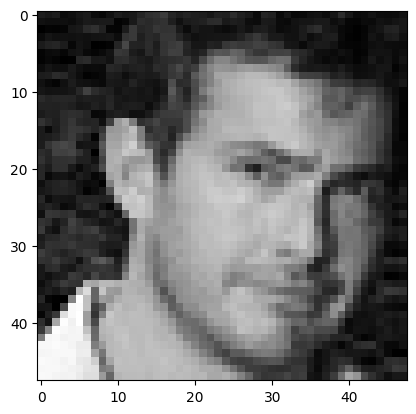

In [52]:
plt.imshow(img_file)

In [53]:
train_dataset_directory = "train"

In [54]:
classes = ["0", "1", "2", "3", "4", "5", "6"]

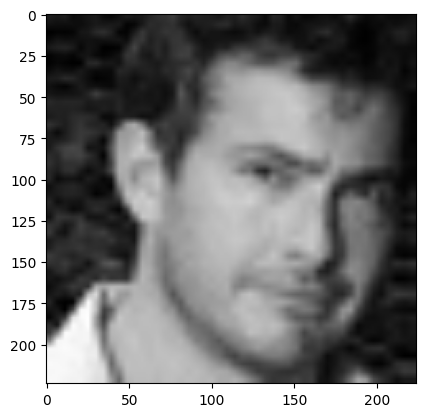

In [55]:
img_size = 224 # 224x224
new_array = cv2.resize(img_file, (img_size, img_size))
plt.imshow(new_array)

In [56]:
new_array.shape

(224, 224, 3)

### Read all images and convert them to array

In [57]:
training_data = []

def create_training_data():
    for category in classes:
        path = os.path.join("dataset", train_dataset_directory, category)
        class_num = classes.index(category)
        for img in os.listdir(path)[:20]:
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

In [58]:
create_training_data()

In [59]:
print(len(training_data))

140


In [60]:
import random

random.shuffle(training_data)

In [61]:
X = [] # features
y = [] # label

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3) # Converting to 4 dimensional array

In [62]:
X.shape

(140, 224, 224, 3)

In [63]:
X[0]

array([[[23, 23, 23],
        [23, 23, 23],
        [24, 24, 24],
        ...,
        [41, 41, 41],
        [41, 41, 41],
        [41, 41, 41]],

       [[23, 23, 23],
        [23, 23, 23],
        [23, 23, 23],
        ...,
        [41, 41, 41],
        [41, 41, 41],
        [41, 41, 41]],

       [[23, 23, 23],
        [23, 23, 23],
        [24, 24, 24],
        ...,
        [41, 41, 41],
        [41, 41, 41],
        [41, 41, 41]],

       ...,

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]]], dtype=uint8)

In [64]:
# Normalizing the data
X = X/255.0

In [65]:
y[100]

6

### Deep Learning model for training - Transfer Learning

In [66]:
from tensorflow import keras
from tensorflow.keras import layers

In [67]:
model = tf.keras.applications.MobileNetV2() ## Pre-trained model

In [68]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

# Transfer Learning - Tuning
* Weights will start from last checkpoint.

In [69]:
base_input = model.layers[0].input

In [70]:
# setting the last checkpoint to the before last layer
base_output = model.layers[-2].output

In [71]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_1')>

In [72]:
# Adding layers to the checkpoint
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output) # 7 Classes, This is classification layernew

In [73]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_5')>

In [74]:
# Creating the model
new_model = keras.Model( inputs= base_input, outputs=final_output)

In [75]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [76]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [77]:
Y = np.array(y)

In [78]:
Y.shape

(140,)

In [79]:
new_model.fit(X, Y, epochs=25)

Epoch 1/25
5/5 [==============================] - 17s 1s/step - loss: 2.1545 - accuracy: 0.1857
Epoch 2/25
5/5 [==============================] - 7s 1s/step - loss: 1.4130 - accuracy: 0.6643
Epoch 3/25
5/5 [==============================] - 6s 1s/step - loss: 0.7138 - accuracy: 0.8857
Epoch 4/25
5/5 [==============================] - 6s 1s/step - loss: 0.2728 - accuracy: 0.9857
Epoch 5/25
5/5 [==============================] - 6s 1s/step - loss: 0.1028 - accuracy: 0.9929
Epoch 6/25
5/5 [==============================] - 6s 1s/step - loss: 0.0416 - accuracy: 0.9857
Epoch 7/25
5/5 [==============================] - 6s 1s/step - loss: 0.0193 - accuracy: 0.9929
Epoch 8/25
5/5 [==============================] - 6s 1s/step - loss: 0.1067 - accuracy: 0.9571
Epoch 9/25
5/5 [==============================] - 6s 1s/step - loss: 0.2968 - accuracy: 0.9357
Epoch 10/25
5/5 [==============================] - 6s 1s/step - loss: 0.2118 - accuracy: 0.9357
Epoch 11/25
5/5 [==============================]

In [80]:
new_model.save("emotion_detector_model.h5")

/home/younes-chouikh/Documents/Projects/FER - Projet Machine Learning/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [81]:
new_model = keras.models.load_model("emotion_detector_model.h5")

In [109]:
frame = cv2.imread("happy-boy.jpg")

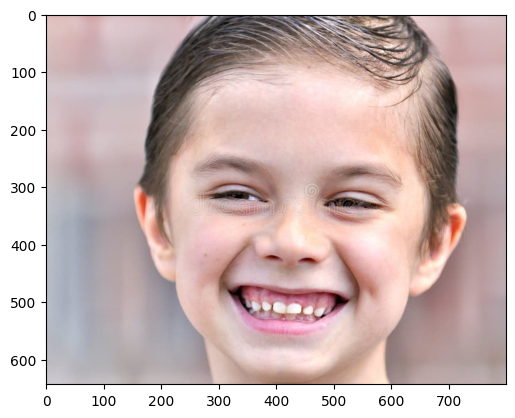

In [110]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [111]:
frame.shape

(643, 800, 3)

In [112]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [113]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [114]:
gray.shape

(643, 800)

In [115]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)

In [116]:
faces

array([[167, 102, 515, 515]], dtype=int32)

In [117]:
for x, y, w, h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for(ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex + ew]

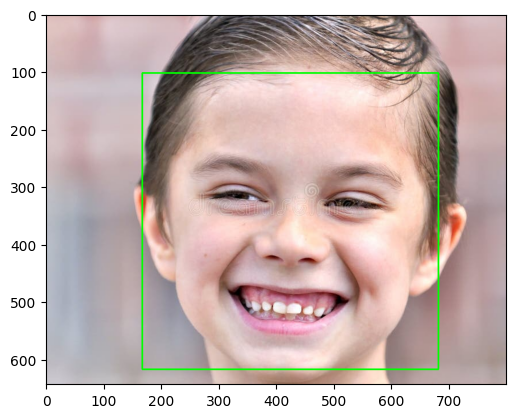

In [118]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

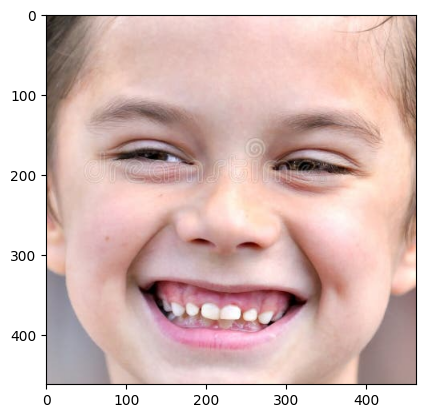

In [119]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [120]:
final_image = cv2.resize(face_roi, (224, 224))
final_image = np.expand_dims(final_image, axis=0) # need fourth dimension
final_image = final_image/255.0 # Normalizing the image

In [122]:
Predictions = new_model.predict(final_image)

1/1 [==============================] - 1s 653ms/step


In [123]:
Predictions

array([[5.4871124e-19, 5.3492638e-25, 1.6865065e-23, 8.7688820e-34,
        2.3312719e-20, 3.5126450e-25, 1.0000000e+00]], dtype=float32)

In [124]:
np.argmax(Predictions)

6

In [149]:
frame = cv2.imread("angry-boy.jpg")

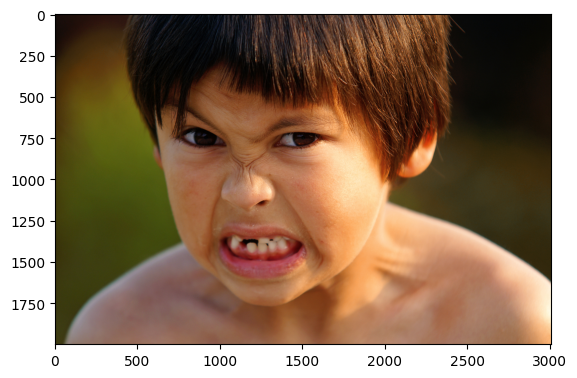

In [150]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [151]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [152]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)

In [153]:
for x, y, w, h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for(ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex + ew]
            

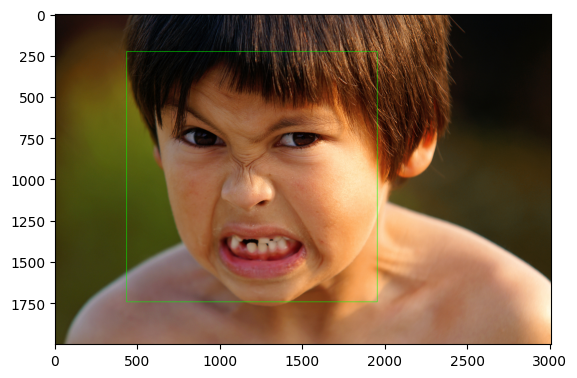

In [154]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

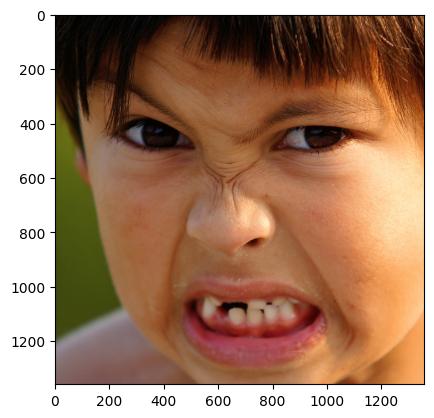

In [155]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [156]:
final_image = cv2.resize(face_roi, (224, 224))

In [157]:
final_image = np.expand_dims(final_image, axis=0) # need fourth dimension

In [158]:
final_image = final_image/255.0 # Normalizing the image

In [159]:
Predictions = new_model.predict(final_image)

1/1 [==============================] - 0s 31ms/step


In [160]:
Predictions

array([[1.3247881e-18, 1.1263476e-23, 1.6057506e-22, 1.1722654e-33,
        7.8998107e-20, 4.8190369e-24, 1.0000000e+00]], dtype=float32)

In [161]:
np.argmax(Predictions)

6

In [126]:
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

In [147]:
rectangle_bgr = (255, 255, 255)
img = np.zeros((500, 500))
text = "Some text in a box!"
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
text_offset_x = 10
text_offset_y = img.shape[0] - 25
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    cap = cv2.VideoCapture(1)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    for x, y, w, h in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = frame[y:y + h, x:x + w]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face not detected")
        else:
            for (ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey: ey + eh, ex:ex + ew]

    final_image = cv2.resize(face_roi, (224, 224))
    final_image = np.expand_dims(final_image, axis=0)  # need fourth dimension
    final_image = final_image / 255.0  # Normalizing the image

    font = cv2.FONT_HERSHEY_SIMPLEX

    Predictions = new_model.predict(final_image)

    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN

    if (np.argmax(Predictions) == 0):
        status = "Angry"
        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1 / 10), y1 + int(h1 / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255))

    elif (np.argmax(Predictions) == 1):
        status = "Disgust"
        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1 / 10), y1 + int(h1 / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255))

    elif (np.argmax(Predictions) == 2):
        status = "Fear"
        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1 / 10), y1 + int(h1 / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255))

    elif (np.argmax(Predictions) == 3):
        status = "Happy"
        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1 / 10), y1 + int(h1 / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255))

    elif (np.argmax(Predictions) == 4):
        status = "Neutral"
        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1 / 10), y1 + int(h1 / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255))

    elif (np.argmax(Predictions) == 5):
        status = "Sad"
        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1 / 10), y1 + int(h1 / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255))
    
    else:
        status = "Surprise"
        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1 / 10), y1 + int(h1 / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255))

    

[ WARN:0@6752.727] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@6752.727] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
[ WARN:0@6753.105] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@6753.105] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


OSError: Cannot open webcam